In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot

from gensim import corpora, models
import pyLDAvis.gensim

%matplotlib inline

//anaconda/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
//anaconda/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
//anaconda/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
//anaconda/lib/python3.5/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

In [2]:
df = pd.read_csv('all_years.csv')

In [3]:
df.head()

//anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
//anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,Unnamed: 0,wordlist,year
0,21427,"['program', 'research', 'design', 'investig', ...",1985
1,21430,"['mammalian', 'alkaloid', 'result', 'condens',...",1985
2,21435,"['exist', 'cognit', 'preceptualmotor', 'defici...",1985
3,21436,"['although', 'alcohol', 'alcohol', 'abus', 're...",1985
4,21439,"['recent', 'neuropsycholog', 'studi', 'detect'...",1985


In [4]:
def get_clean_wordlist(series):
    texts = list(series)
    
    # clean wordlist
    clean_texts = []
    for text in texts:
        text = text[2:-2].split("', '")
        clean_texts.append(text)
    return clean_texts

In [5]:
texts = get_clean_wordlist(df.wordlist)

In [6]:
# get unique words list
dictionary = corpora.Dictionary(texts)

In [7]:
# get document-term matrix
corpus = [dictionary.doc2bow(tex) for tex in texts]

# How many neuro projects a year overall?

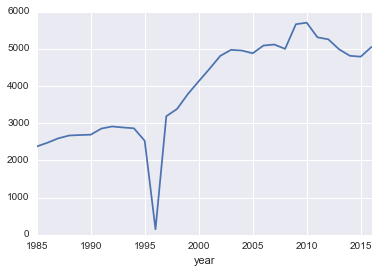

In [8]:
df.groupby('year')['wordlist'].count().plot()

- There is a trend of an increase funding for neuroscience R01s and then stagnation from about 2005.
- Why the sudden drop in abstracts in 1996? Digging into the dataframe for 1996, I found that many of the abstracts were not recorded and thus were given NaN values -- for all R01s in 1996, only 1024 of them had abstract text. For this project, it is fine to simply drop all the data for 1996 since I haver 30 years of data.

In [13]:
# drop 1996 from df
df = df[df.year != 1996]

# Let's try some different parameters for LDA.

In [16]:
def lda(corpus, num_topics, passes, alpha):
    lda = models.ldamodel.LdaModel(corpus, num_topics=num_topics, passes=passes, alpha=alpha)
    followers_data =  pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    pyLDAvis.display(followers_data)

    pyLDAvis.save_html(followers_data, 'LDA_' + str(num_topics) + '_' + str(num_passes) + '_' + str(alpha) + '.html')
    
    return lda

In [ ]:
ldas_dict = {}
num_topics = [8, 15, 25, 40]
passes = 10
alpha = 0.01

for topic in num_topics:
    lda = lda(corpus, topic, passes, alpha)
    ldas_dict[topic] = lda

# Quantification and visualization

## How big is each topic overall?

I will try to quantify how big each topic is in two ways. First, split up project based on topic probability. And get topic size by summing up proportions of each project inside it.

In [ ]:
def get_topic_size_split_project(num_topics, corpus, lda):
    
    # initialize topic dict
    topic_dict = {}
    for j in range(num_topics):
        topic_dict[j] = 0
    
    # add project proportions into each topic
    for i in range(len(corpus)):
        doc_topics = lda.get_document_topics(corpus[i])
        for topic in doc_topics:
            topic_dict[topic[0]] += topic[1]
    
    return topic_dict

Second, bin the entire project into a topic space based on highest probability.

In [ ]:
def get_topic_size_whole_project(num_topics, corpus, lda):
    from operator import itemgetter
    
    # initialize topic dict
    topic_dict = {}
    for j in range(num_topics):
        topic_dict[j] = 0
    
    # add whole projects into topic
    for i in range(len(corpus)):
        doc_topics = lda.get_document_topics(corpus[i])
        np_topics = np.array(doc_topics)
        index = np.argmax(np_topics, axis=0)[1]
        topic_dict[doc_topics[index][0]] += 1
        
    assert (sum(topic_dict.values()) == len(corpus)), "algo wrong"
    return topic_dict

In [ ]:
def topic_size_scatter(topic_dict):
    td_list = [(k,v) for k,v in topic_dict.items()] 
    x_td_list = [x[0] for x in td_list]
    y_td_list = [x[1] for x in td_list]
    return x_td_list, y_td_list

### How similar are the two ways I choose to represent topic size?

In [ ]:
def topic_size(num_topics, corpus, lda):

    split_dict = get_topic_size_split_project(25, corpus, lda)
    whole_dict = get_topic_size_whole_project(25, corpus, lda)

    s_x, s_y = topic_size_scatter(split_dict)
    w_x, w_y = topic_size_scatter(whole_dict)

    pyplot.scatter(s_x, s_y, color='b')
    pyplot.scatter(w_x, w_y, color='r')
    
    return whole_dict

In [ ]:
whole_dict = topic_size(num_topics, corpus, lda)

Pretty similar! I am going to use whole_dict here, since both ways of representing topic size yields the same information.

## How has the size of each topic changed over time?

In [ ]:
# get labels for each topic

def get_topic_labels(num_topics, corpus, lda):
    topic_labels = []
    for i in range(len(corpus)):
        doc_topics = lda.get_document_topics(corpus[i])
        np_topics = np.array(doc_topics)
        index = np.argmax(np_topics, axis=0)[1]
        topic_labels.append(doc_topics[index][0])
    return topic_labels
df['topic'] = get_topic_labels()

In [ ]:
# Export things
save_things = pd.DataFrame()
save_things['topics'] = topic_head.values()
save_things['s_y'] = s_y
save_things['w_y'] = w_y

df_neuro_granttype['corpus'] = corpus